In [262]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [263]:
prefix="find-max"
prefix='cryptonce-kernel'
prefix='cryptonce-max'
prefix='cryptonce-max-5g'
prefix='cryptonce-v2-trace'
prefix='cryptonce-final'
prefix='cryptonce-v1'
prefix='sockperf-eval'

In [3]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).median(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir, coalesce=True):
    if not isinstance(res_dir, list):
        res_dir = [res_dir]
    
    throughput_csv = []
    for k,i in enumerate(res_dir):
        tmp = pd.read_csv(f"../{i}/summary/server/throughput-sar.csv")
        tmp["key"] = k
        throughput_csv.append(tmp)
    throughput_csv = pd.concat(throughput_csv, axis=0)
#     throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    if coalesce:
        net_wg = average_data(throughput_wg)
        net_phy = average_data(throughput_phy)
    else:
        net_wg = throughput_wg
        net_phy = throughput_phy
    
    return net_wg, net_phy

def import_cpu(res_dir, coalesce=True):
    if not isinstance(res_dir, list):
        res_dir = [res_dir]

    cpu_csv = []
    for k,i in enumerate(res_dir):
        tmp = pd.read_csv(f"../{i}/summary/server/cpu-sar.csv")
        tmp["key"] = k
        cpu_csv.append(tmp)
    cpu_csv = pd.concat(cpu_csv, axis=0)
    cpu_csv['used'] = 100 - cpu_csv['idle']

    if coalesce:
        cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    else:
        cpu = cpu_csv

    per_core = cpu[cpu.core != -1].reset_index(drop=True)
    global_cpu = cpu[cpu.core == -1].reset_index(drop=True)
    
    return global_cpu, per_core

def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).median().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir, coalesce=True):
    if not isinstance(res_dir, list):
        res_dir = [res_dir]
    
    df_t = []
    for k, e in enumerate(res_dir):
        for i in range(1, 11):
            try:
                latency_csv = pd.read_csv(
                    f"../{e}/summary/clients/latency-{i}.csv",
                    names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                    skiprows=1
                )
                latency_csv['key'] = k
            except:
                continue
            if coalesce:
                latency_df = average_data(latency_csv, keep=['cpu', 'client'])
            else:
                latency_df = latency_csv

            latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
            latency_df['node'] = i
            df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    if coalesce:
        latency_df = df.groupby(['cpu', 'client']).median().reset_index()
    else:
        latency_df = df
    return latency_df

In [4]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"    
    with open(filename) as file:
        test_config = file.read().strip()
    
    yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
    with open(yaml_file) as file:
        content = yaml.load(file, yaml.FullLoader)
        flow = content['all']['vars']['bandwidth']
    
    if test_config != 'default':
        use_case, suffix = test_config.split('--')
        crypted = suffix.split('-')[0]
        threaded = "-".join(suffix.split('-')[1:])
#         threaded = len(suffix.split('-')[1:]) == 2
    else:
        use_case = wg_variant = traffic = flow = None
        
    return test_config, use_case, flow, crypted, threaded

In [7]:
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [8]:
# 1. find yes and put it at start
# 2. find no and put it at second

def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res[4] == val:
            return k

In [9]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

In [200]:
skip = 1
names = ['VANILLA', 'CRYPTONCE']
naming = {
    'yes': 'VANILLA',
    'partial': "CRYPTONCE"
}
names_2 = ['VANILLA-v2', 'CRYPTONCE-v2']
naming_2 = {
    'yes': 'VANILLA-v2',
    'partial': "CRYPTONCE-v2"
}
ms = ['x', 'o', 's']
colors = ['black', 'red']

In [254]:
def compute_improvement(res_dirs, importer, metric, naming=naming):
    base = res_dirs[0]
    other = res_dirs[1]
    
    df_base = importer(base[0]).reset_index(drop=True)
    df_base = df_base[df_base['client'] != skip]
    df_base = df_base.set_index('client')

    df_other = importer(other[0]).reset_index(drop=True)
    df_other = df_other[df_other['client'] != skip]
    df_other = df_other.set_index('client')
    impr = (- df_other + df_base) * 100 / df_base
    diff = (- df_other + df_base)
    

    clients = list(diff.index)
    data_impr = list(impr[metric])
    data_diff = list(diff[metric])
    data = {
        'client': clients,
        'improvement': data_impr,
        'difference': data_diff,
    }

    out = pd.DataFrame(data).set_index('client')

    for res_dir in res_dirs:
        df = importer(res_dir[0])
        df = df[df['client'] != skip].set_index('client')
        out[naming[res_dir[4]]] = df[metric]
    
    return out

def cpu_importer(arg):
    return import_cpu(arg)[0]

def plot_improvement(out, savefig=None, ylabel='99th Tail Latency in ms', ylim=[0, 1], space=.01,
                     names=names, annotate='improvement', colors=colors, n_cols=1, figsize=(4, 3),
                     legend_size=10, columnspacing=1.5, width=.8):
    with plt.style.context(['science', 'ieee']):
        ax = out[names].plot.bar(
            ylim=ylim, width=width,
            xlabel='Clients', ylabel=ylabel,
            grid=True, color=colors, figsize=figsize,
        )

            
        if annotate is not None:
            for k, i in enumerate(out.index):
                suffix = "\%" if annotate == "improvement" else ""
                max_height = out.loc[i, names[0]]  # Position at the higher bar
                ax.text(k, max_height + space, f'{out.loc[i, annotate]:.2f}{suffix}', 
                        ha='center', fontsize=12)

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":legend_size}, ncol=n_cols, columnspacing=1.5)
        if savefig is not None:
            plt.savefig(savefig, dpi=300)

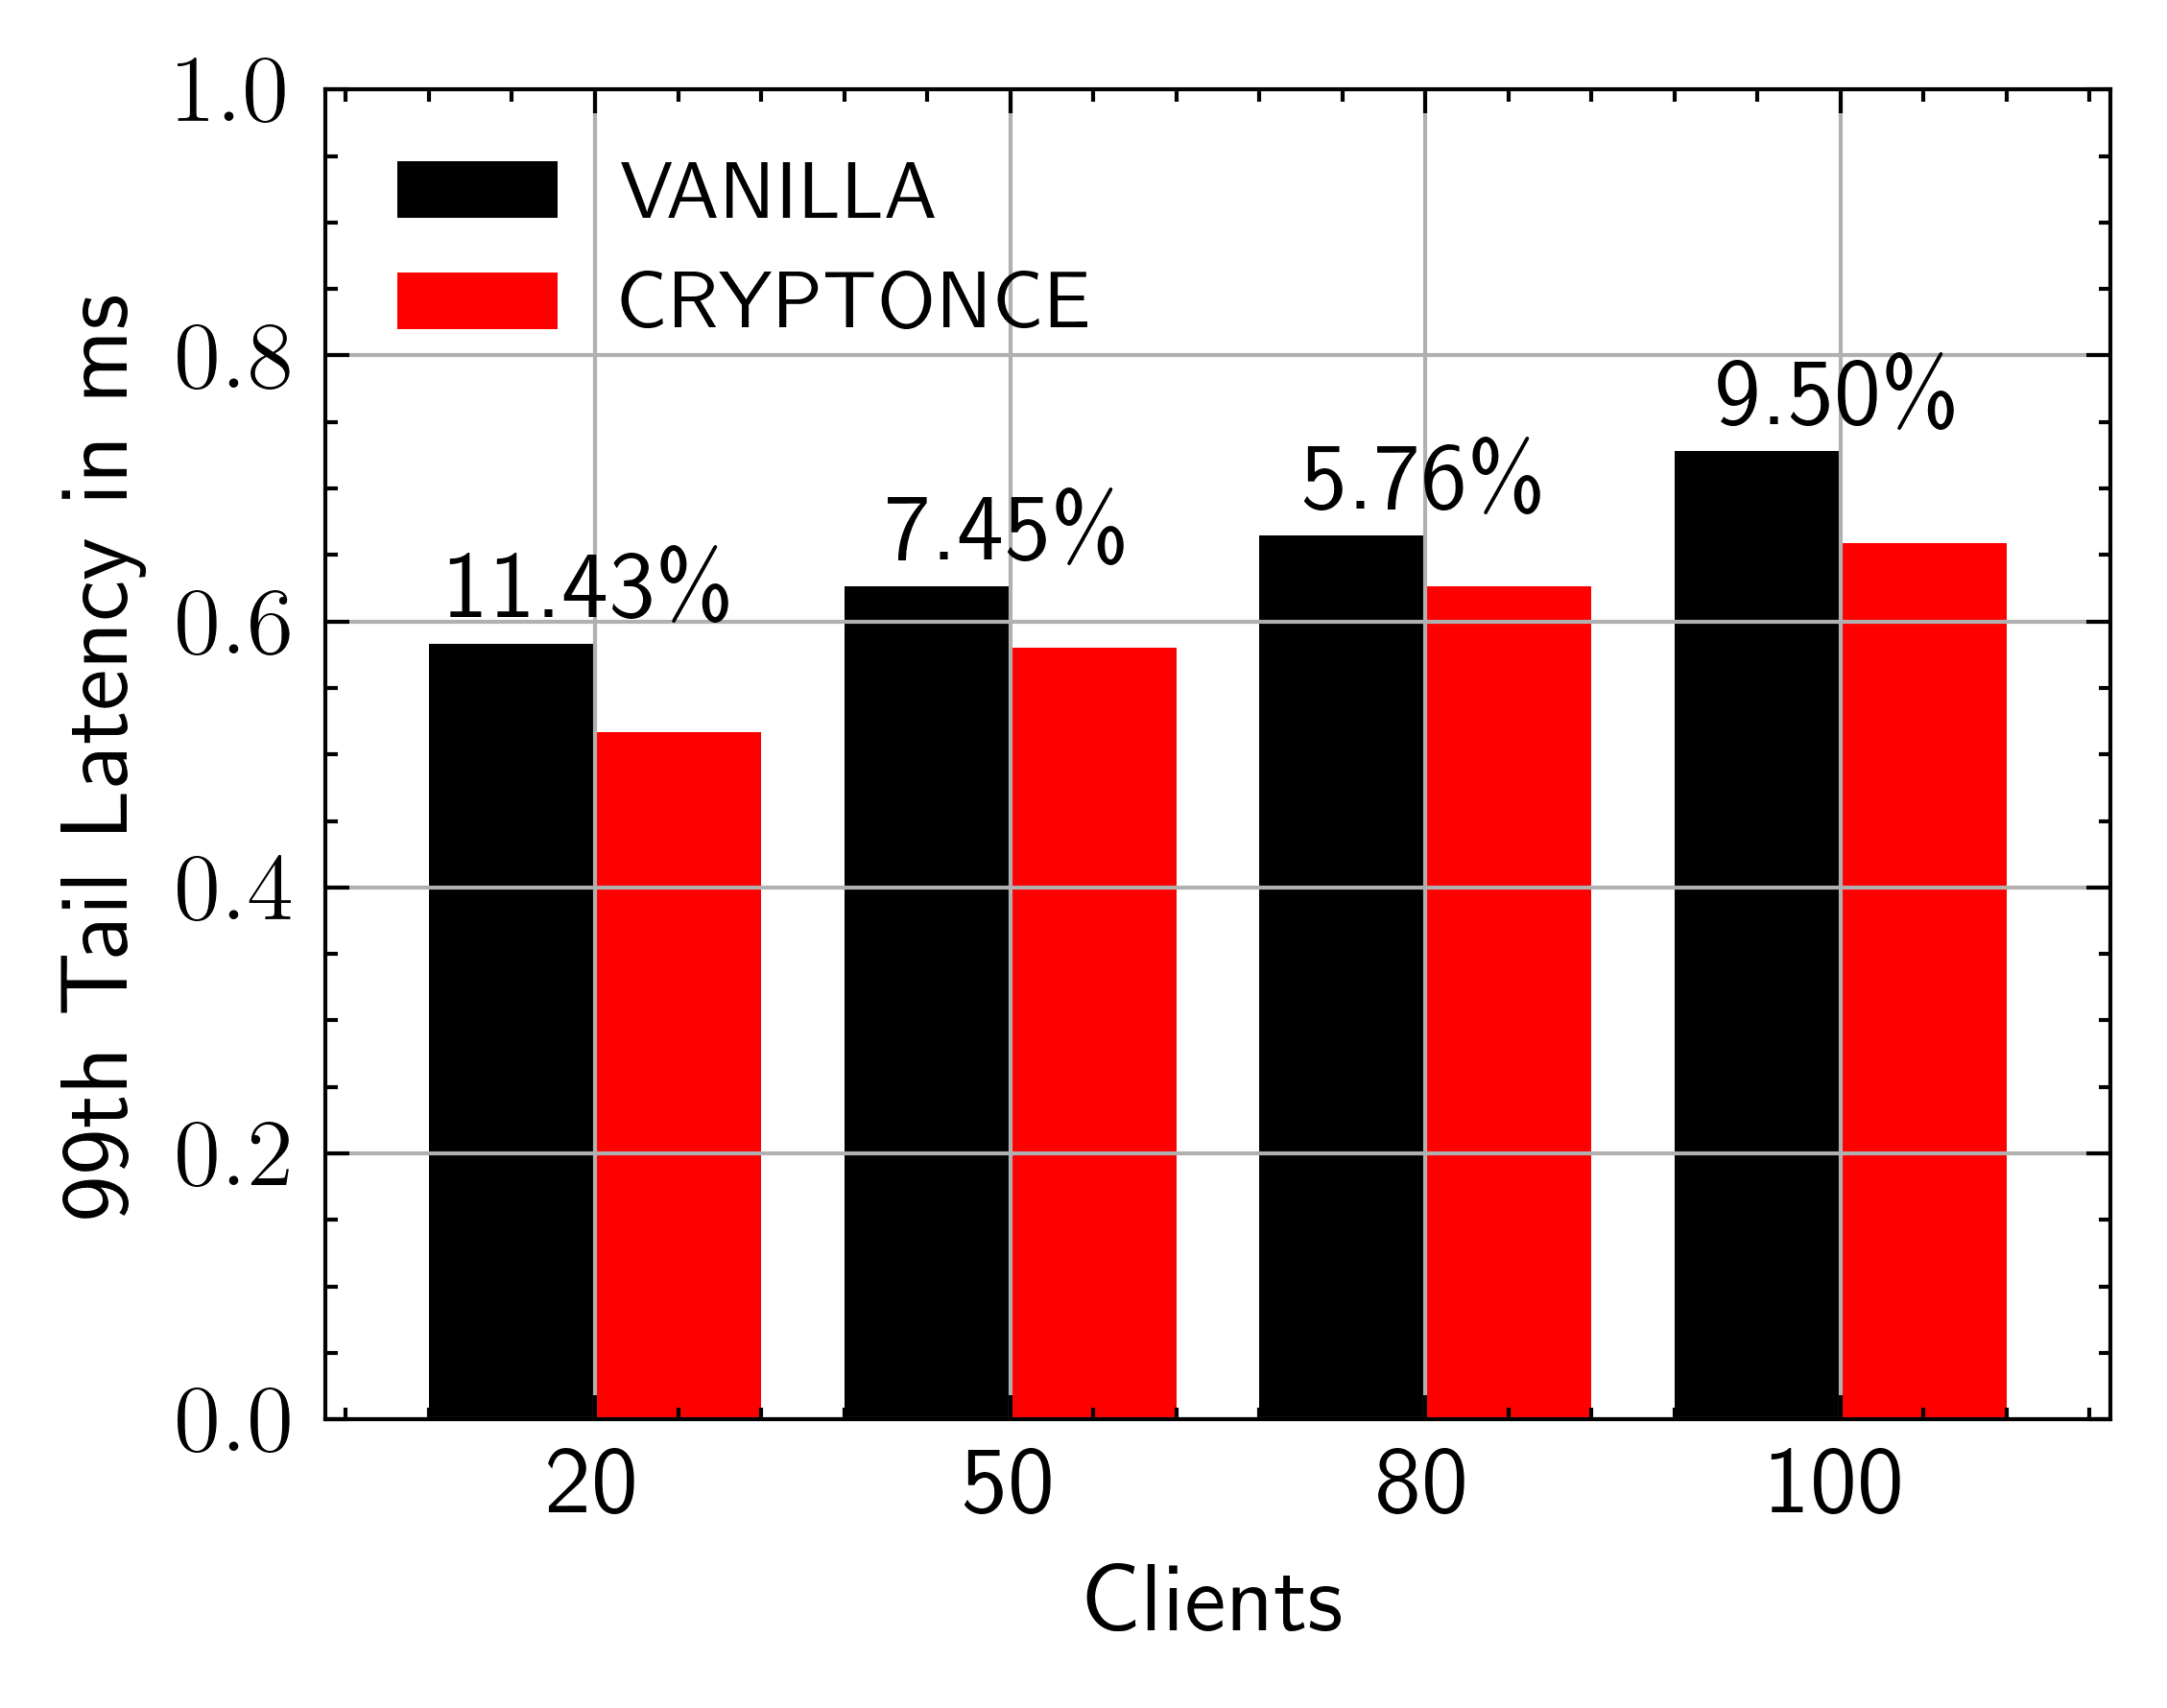

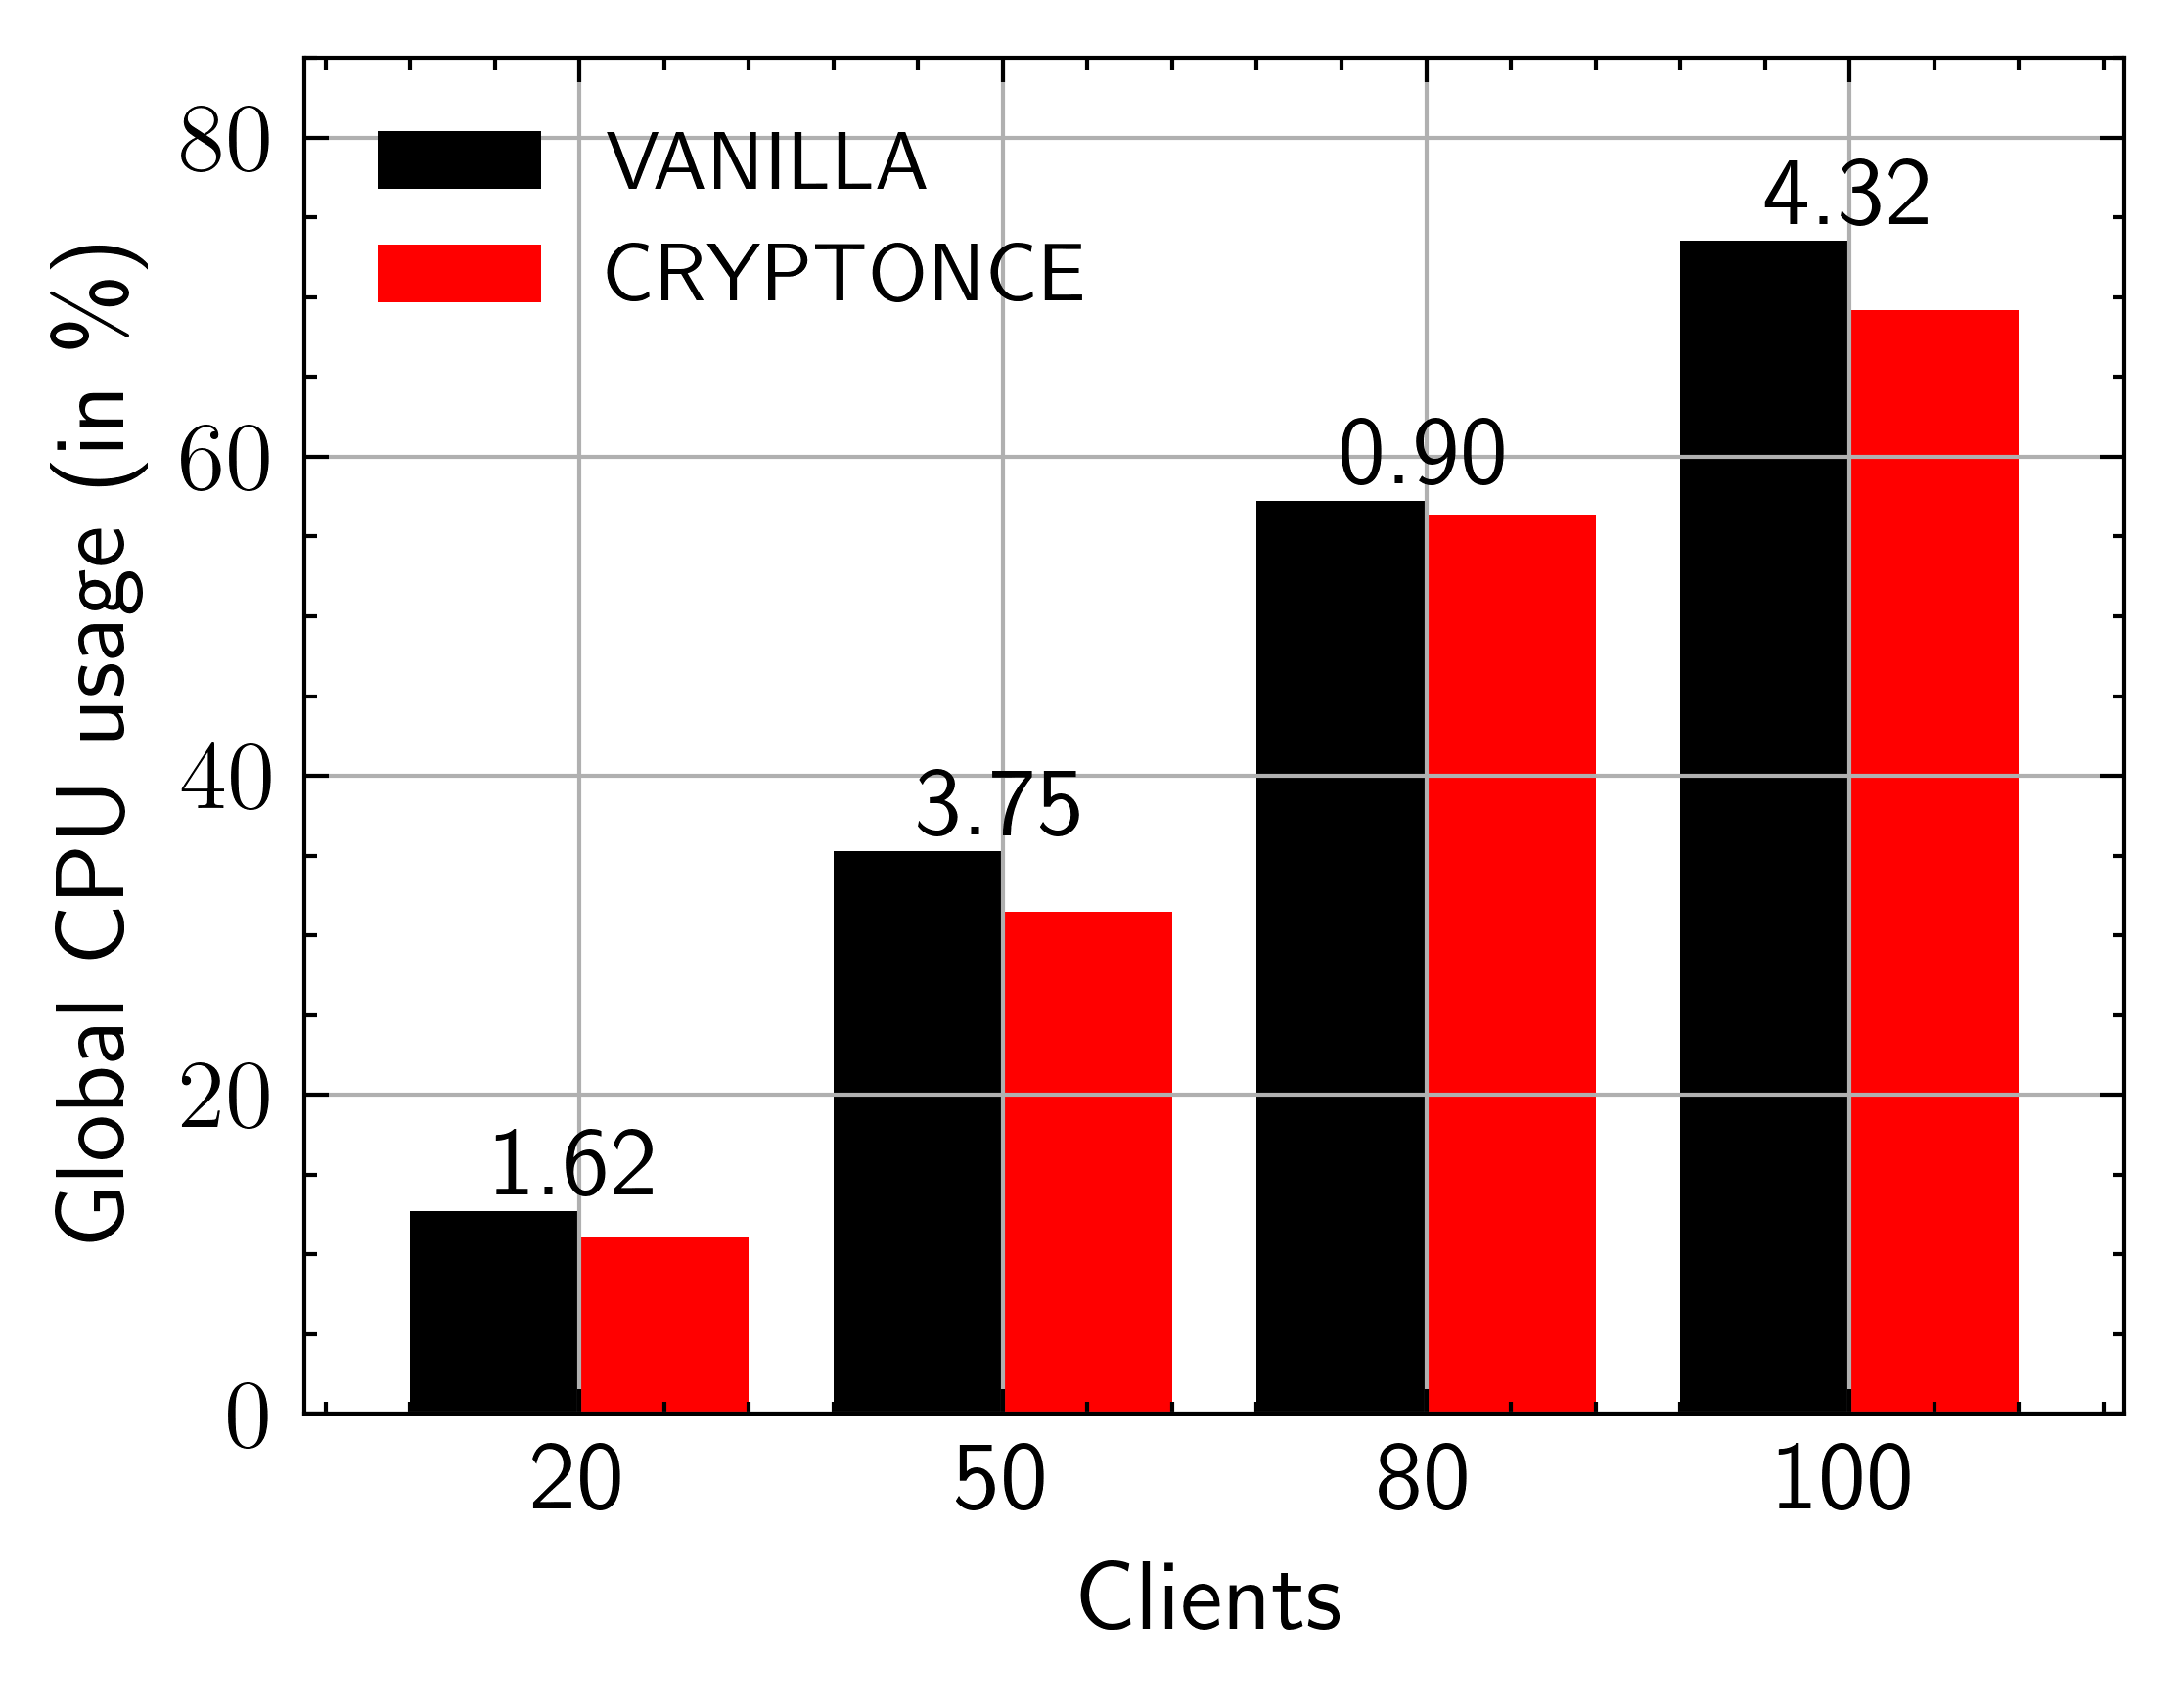

In [255]:
prefix='cryptonce-v1-1'
try:
    os.makedirs(f"../graphs/{prefix}")
except:
    pass
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]
index = find_index(res_dirs, 'no')
res_dirs.pop(index)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)


out_latency = compute_improvement(res_dirs, import_latency, '99th')
plot_improvement(out_latency, ylabel="99th Tail Latency in ms", 
                 ylim=[0, 1], space=.02, 
                 savefig=f"../graphs/{prefix}/latency.pdf")

out_cpu = compute_improvement(res_dirs, cpu_importer, 'used')
plot_improvement(out_cpu, ylabel="Global CPU usage (in \%)", 
                 ylim=[0, 85], space=1, annotate='difference',
                savefig=f"../graphs/{prefix}/cpu.pdf")

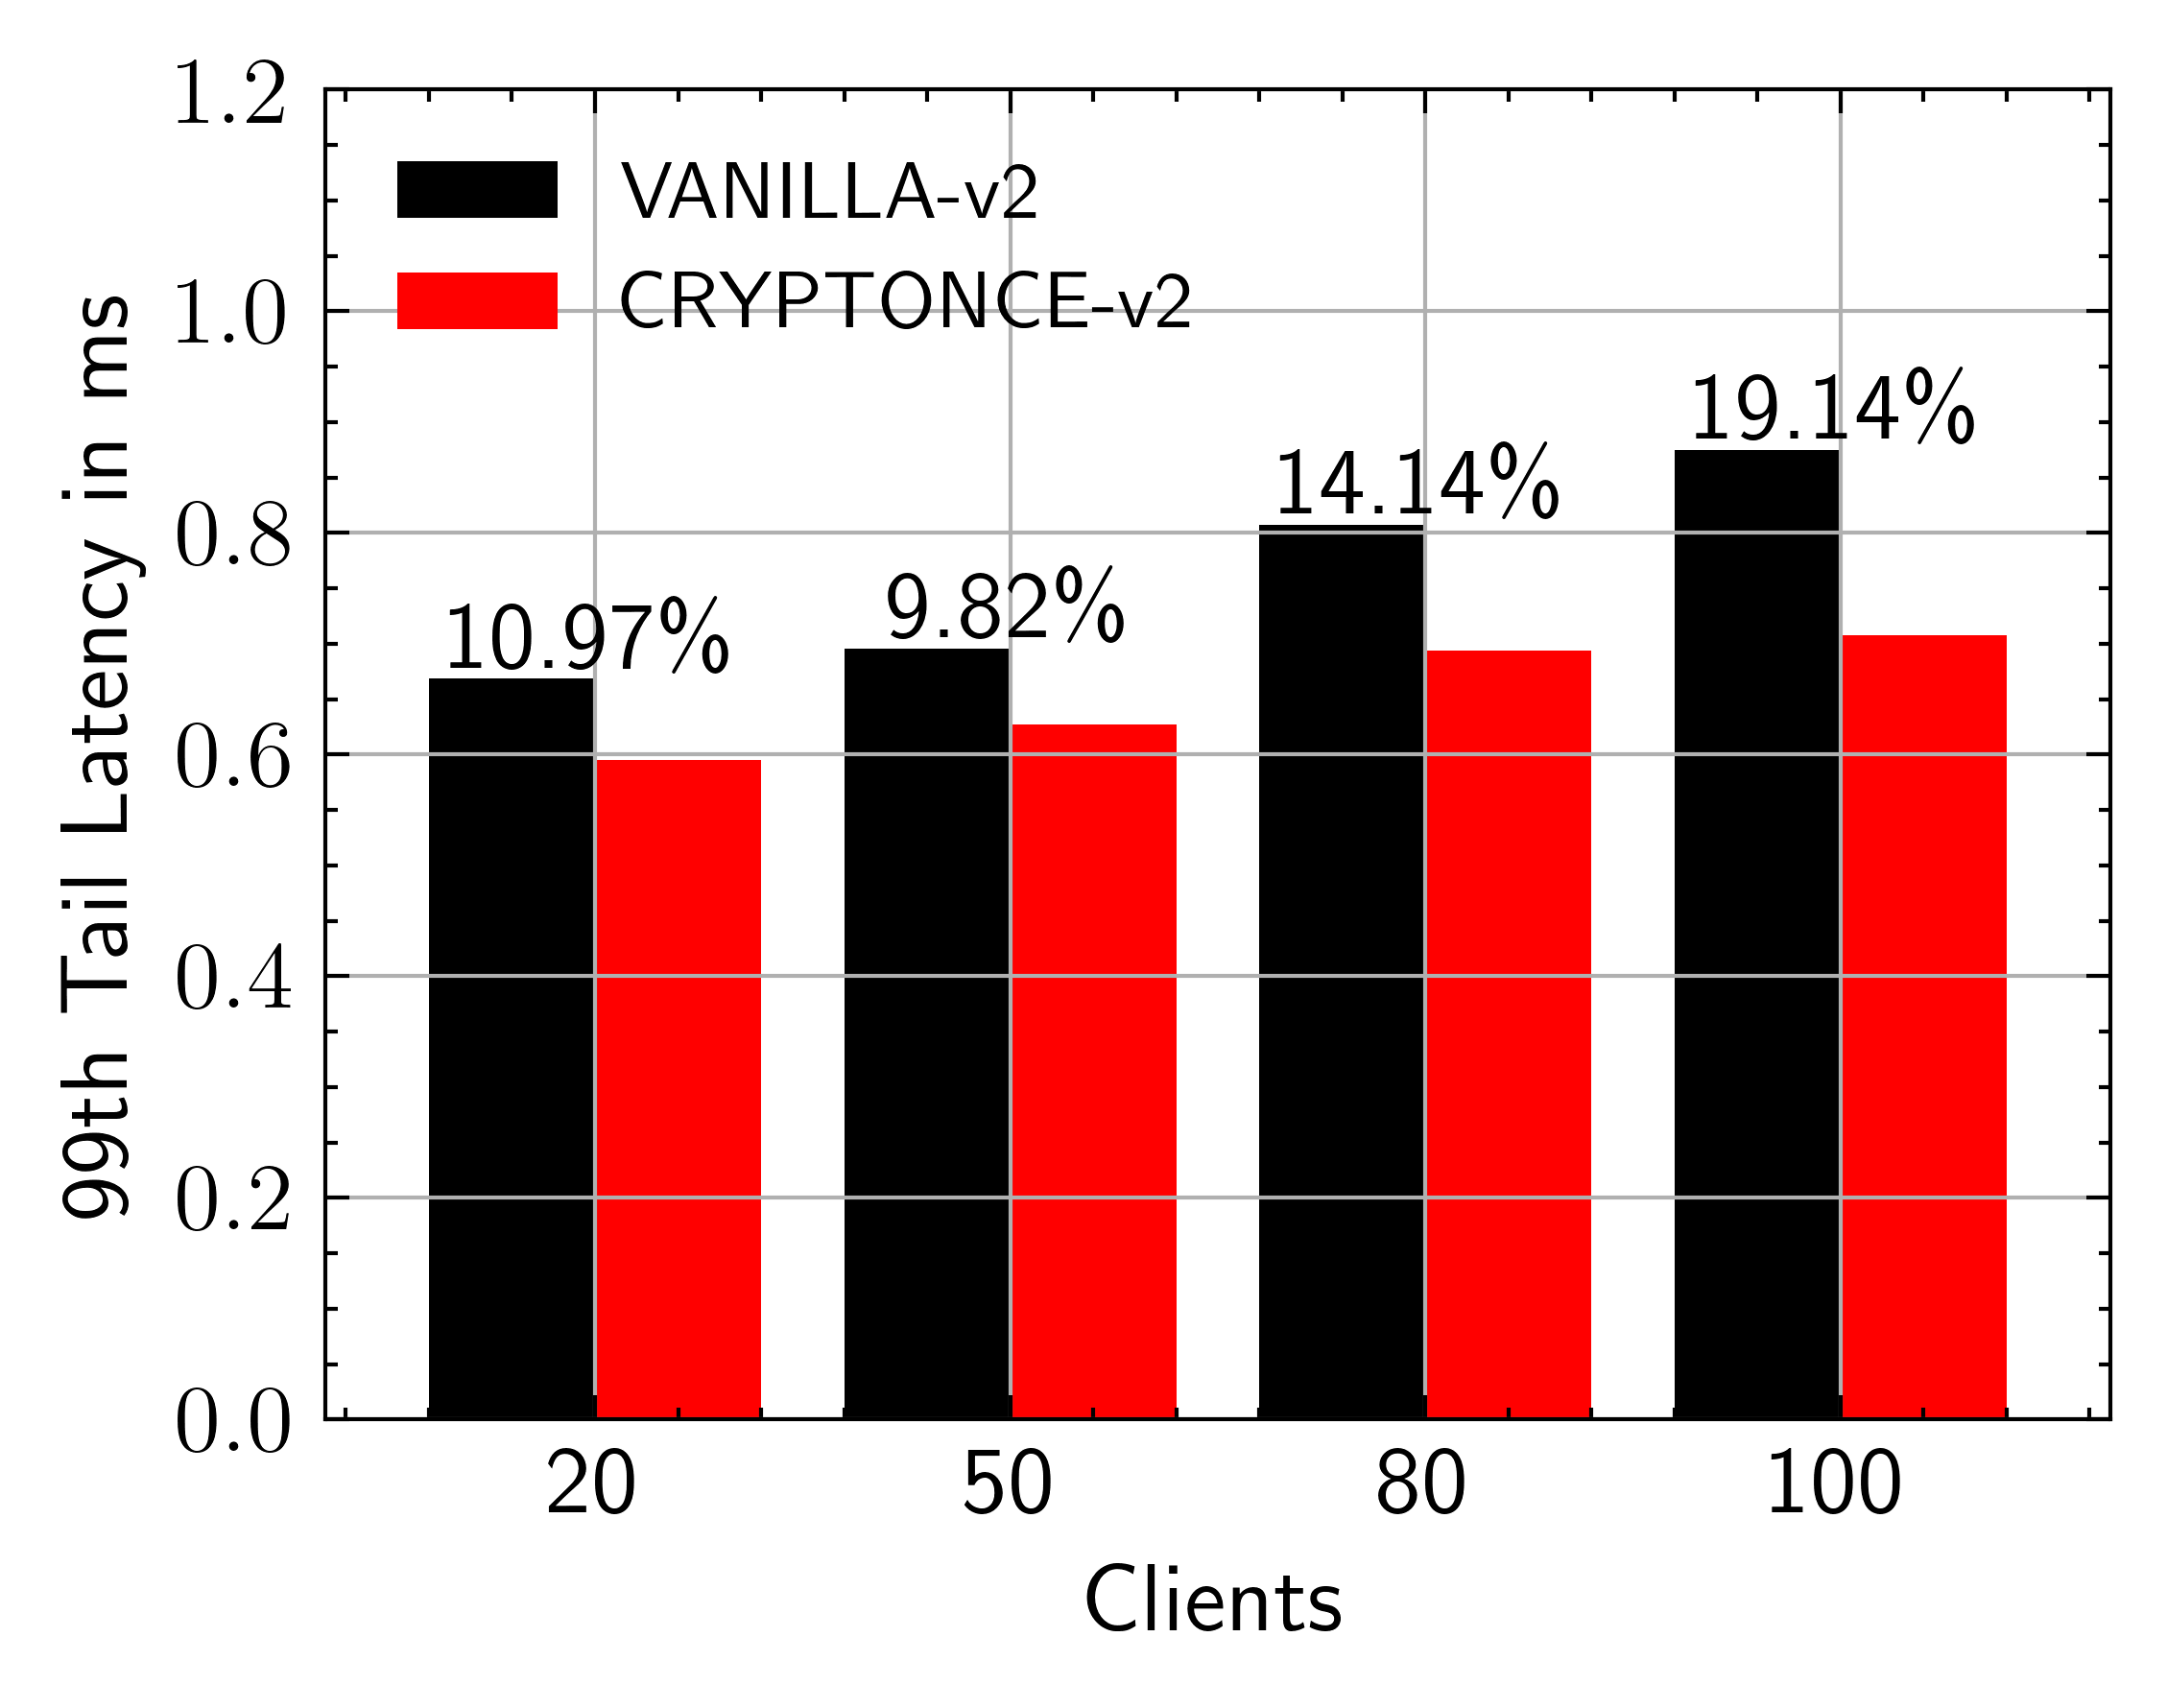

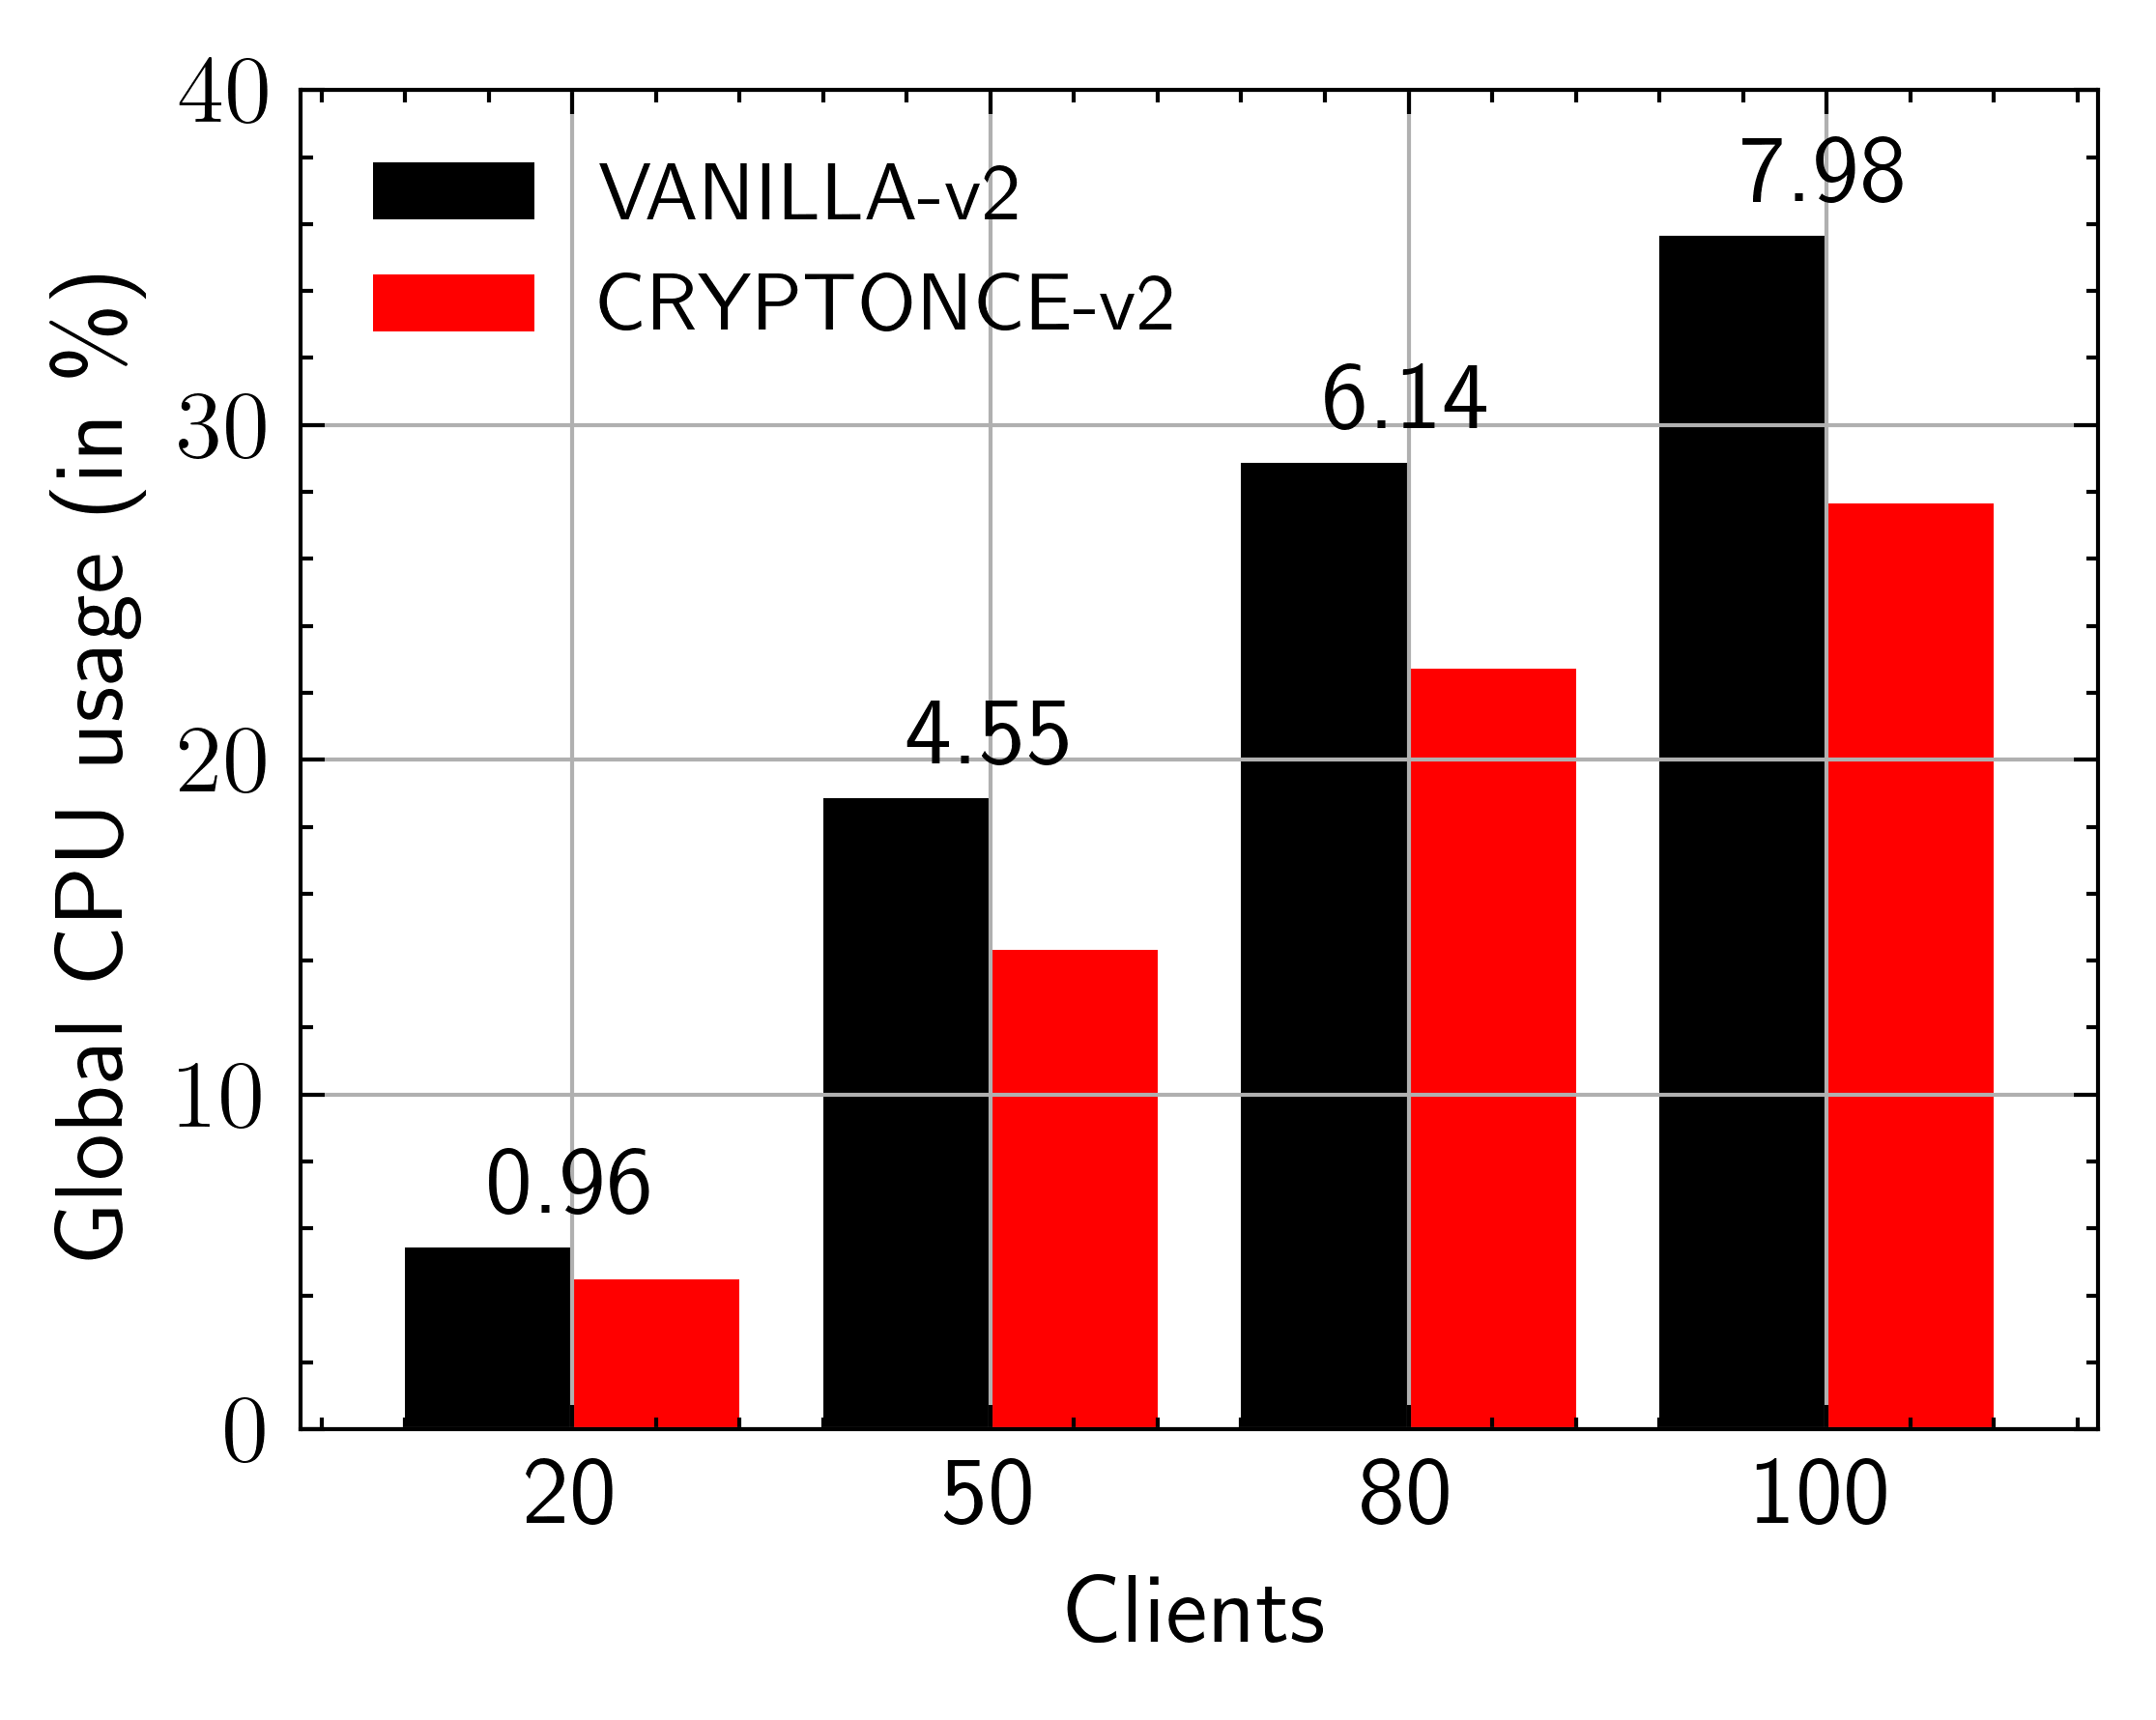

In [256]:
prefix='cryptonce-v2-2'
try:
    os.makedirs(f"../graphs/{prefix}")
except:
    pass
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]
index = find_index(res_dirs, 'no')
res_dirs.pop(index)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)


out_2_latency = compute_improvement(res_dirs, import_latency, '99th', naming=naming_2)
plot_improvement(out_2_latency, ylabel="99th Tail Latency in ms", 
                 ylim=[0, 1.2], space=.01,  names=names_2,
                 savefig=f"../graphs/{prefix}/latency.pdf")

out_2_cpu = compute_improvement(res_dirs, cpu_importer, 'used', naming=naming_2)
plot_improvement(out_2_cpu, ylabel="Global CPU usage (in \%)", 
                 ylim=[0, 40], space=1, names=names_2, annotate='difference',
                savefig=f"../graphs/{prefix}/cpu.pdf")

        improvement  difference    VANILLA  CRYPTONCE  improvement  \
client                                                               
20        12.788866    1.623333  12.693333  11.070000    17.702910   
50        10.628339    3.746667  35.251667  31.505000    24.100751   
80         1.574551    0.901667  57.265000  56.363333    21.264434   
100        5.870487    4.316667  73.531667  69.215000    22.387432   

        difference  VANILLA-v2  CRYPTONCE-v2  
client                                        
20        0.963333    5.441667      4.478333  
50        4.545000   18.858333     14.313333  
80        6.138333   28.866667     22.728333  
100       7.980000   35.645000     27.665000  


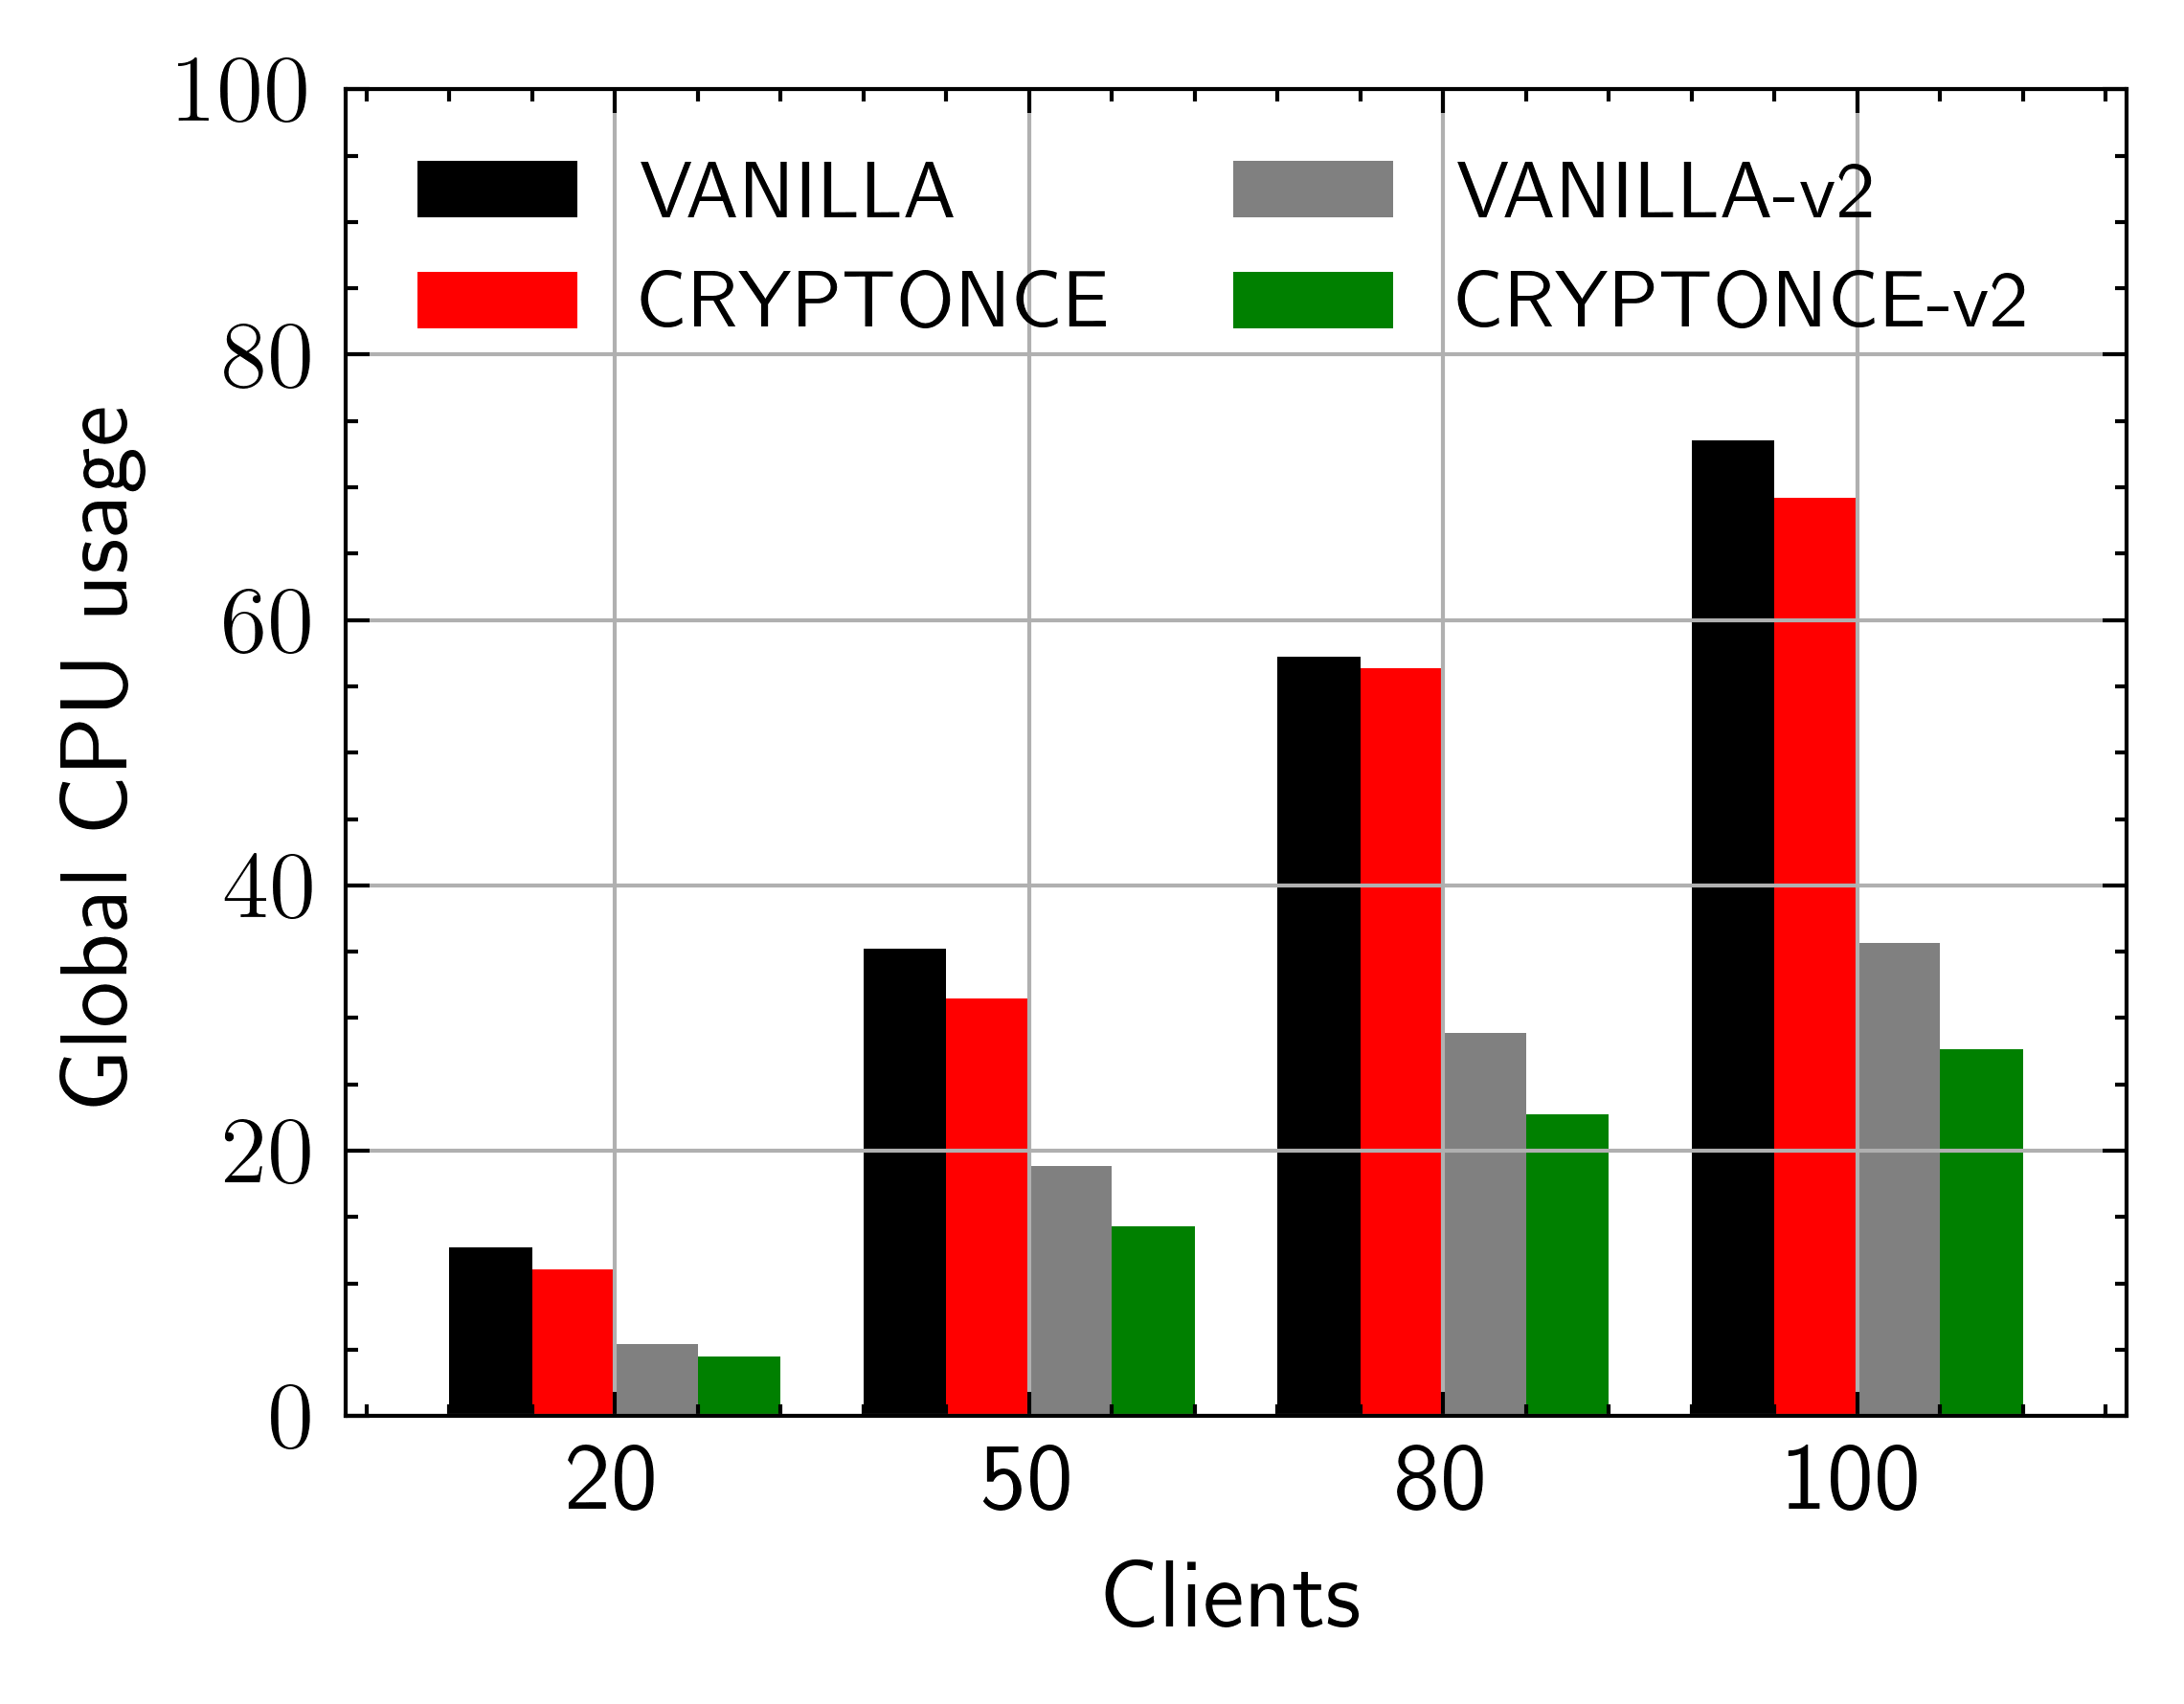

In [258]:
out_cpu_final = pd.concat([out_cpu, out_2_cpu], axis=1)
names_final = names + names_2
colors = ['black', 'red', 'gray', 'green']
plot_improvement(out_cpu_final, names=names_final, 
                 ylabel="Global CPU usage", 
                 ylim=[0, 100], space=1, colors=colors, annotate=None, 
                 n_cols=2, legend_size=10, figsize=(4, 3),
                savefig=f"../graphs/{prefix}/cpu_1_2.pdf"
)
print(out_cpu_final)

        improvement  difference   VANILLA  CRYPTONCE  improvement  difference  \
client                                                                          
20        11.428571    0.066667  0.583333   0.516667    10.972569    0.073333   
50         7.446809    0.046667  0.626667   0.580000     9.820359    0.068333   
80         5.764411    0.038333  0.665000   0.626667    14.138287    0.114167   
100        9.496568    0.069167  0.728333   0.659167    19.142857    0.167500   

        VANILLA-v2  CRYPTONCE-v2  
client                            
20        0.668333      0.595000  
50        0.695833      0.627500  
80        0.807500      0.693333  
100       0.875000      0.707500  


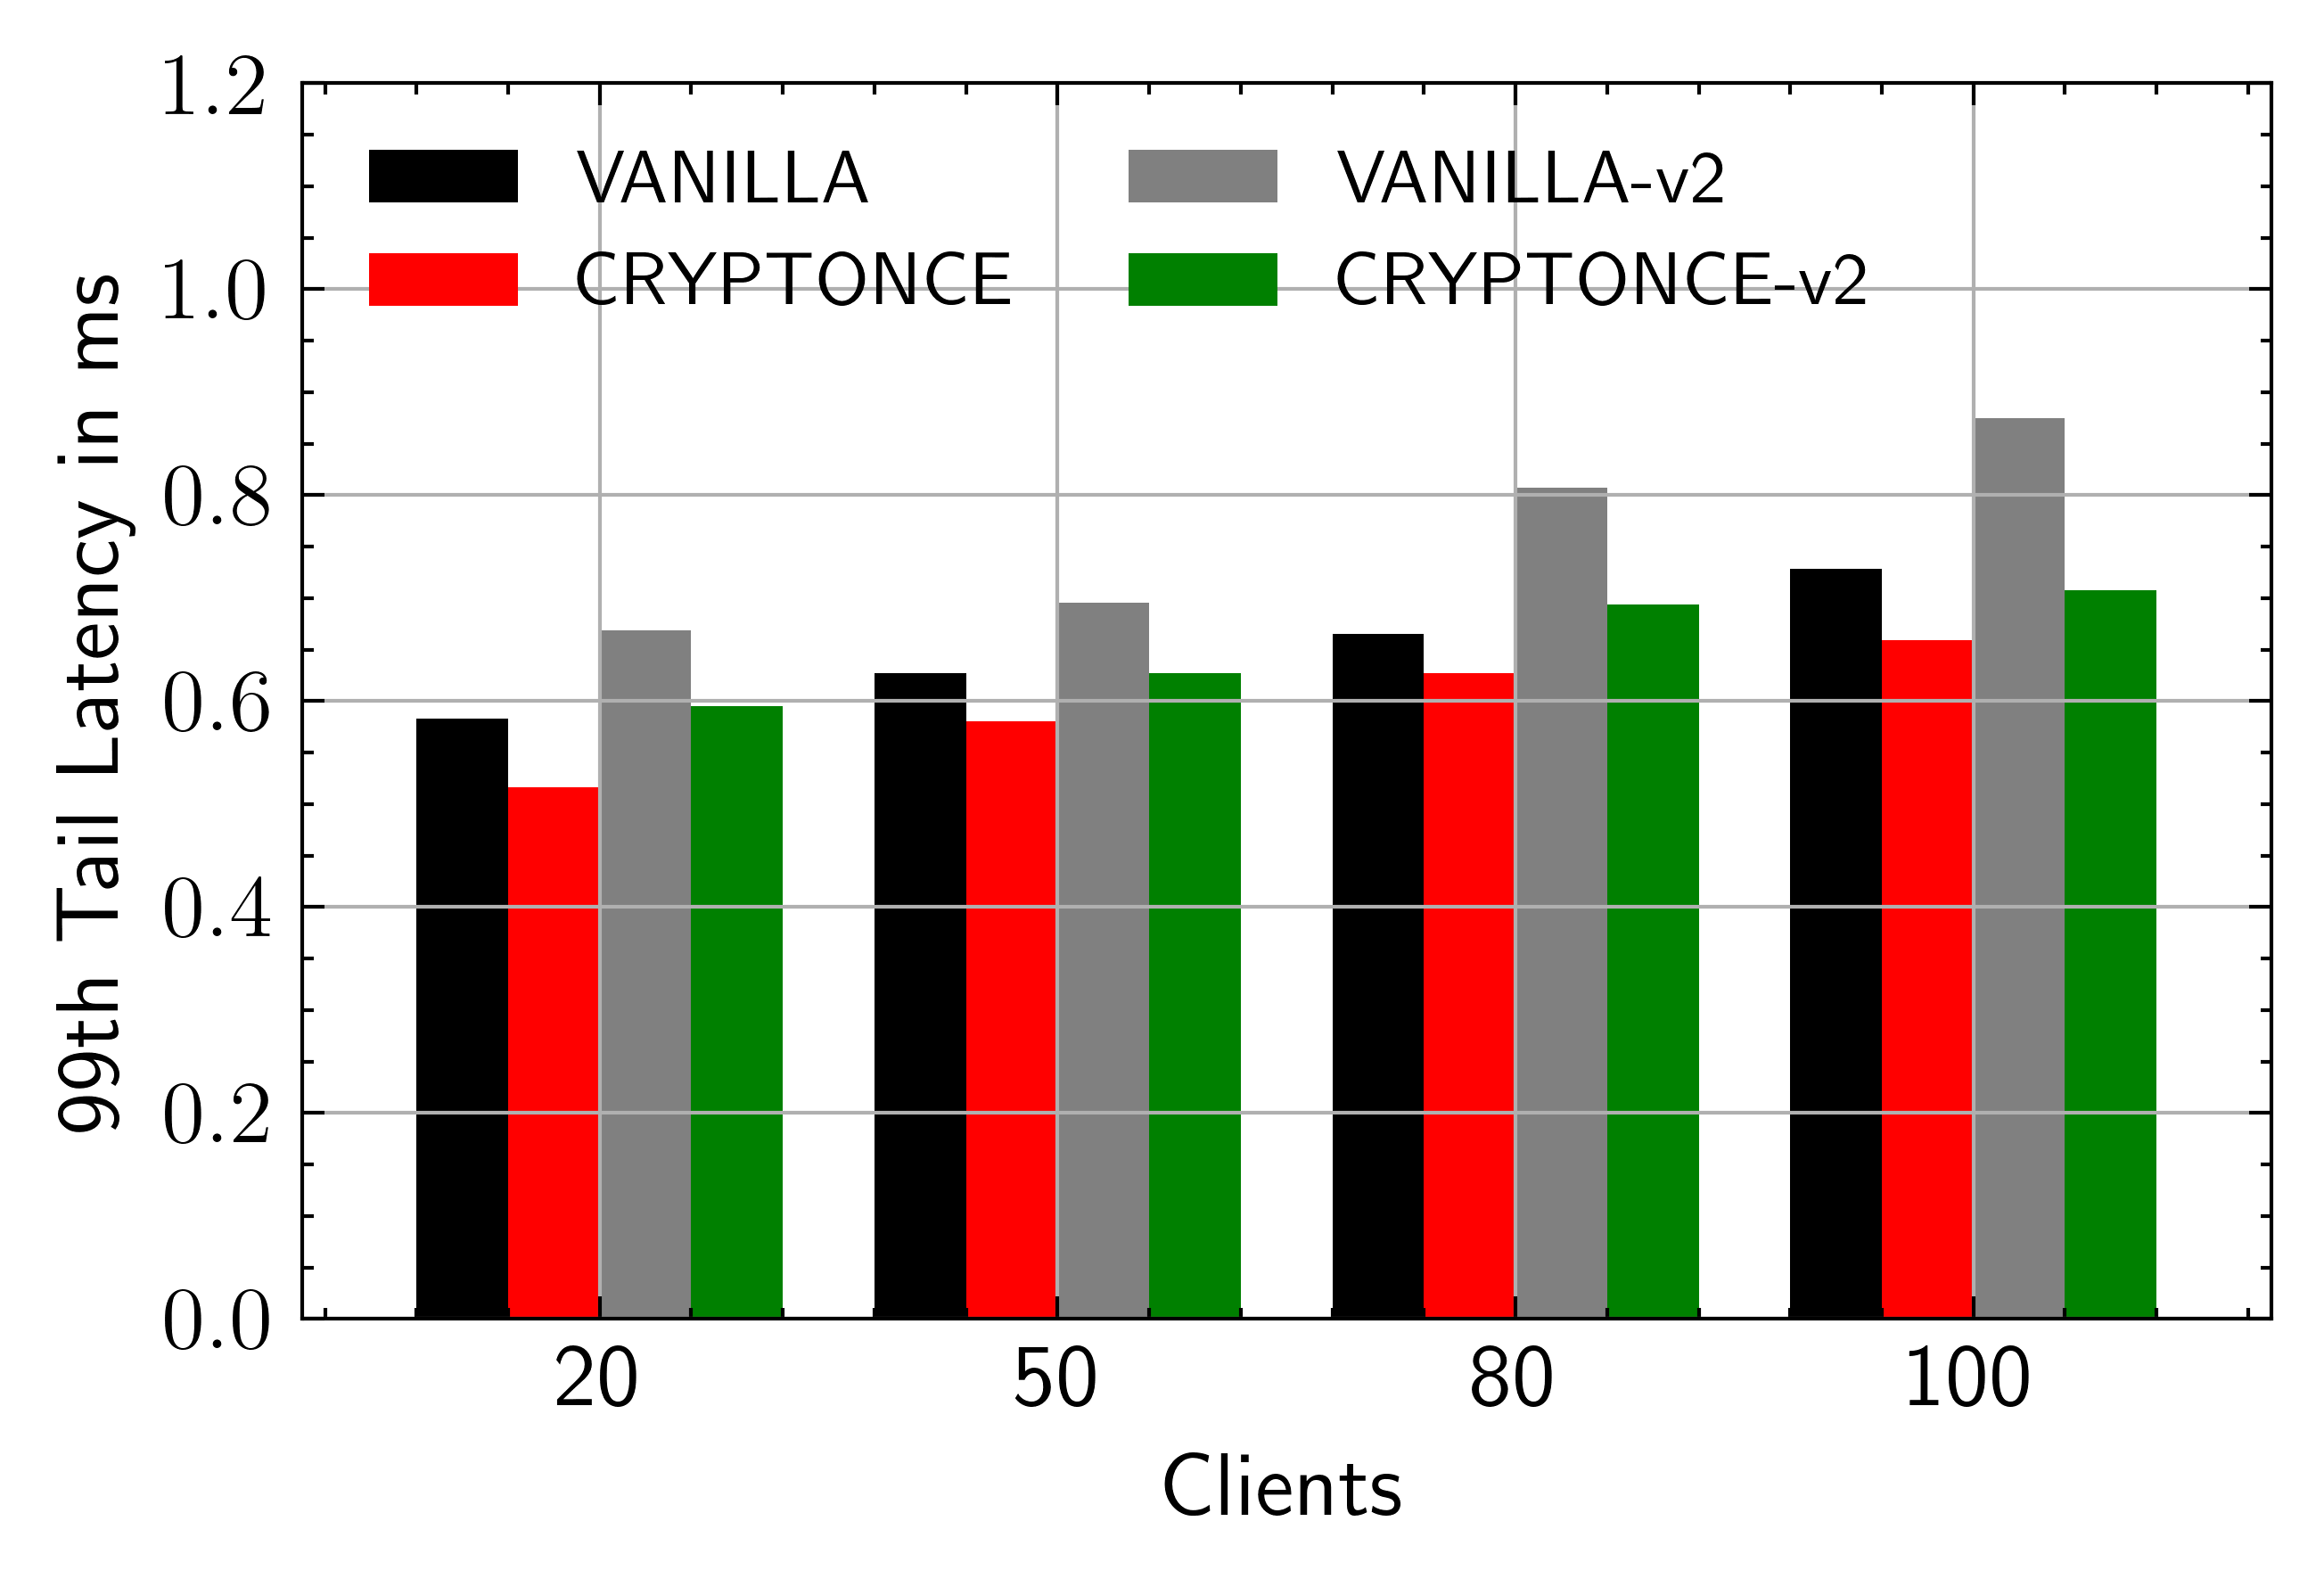

In [259]:
out_latency_final = pd.concat([out_latency, out_2_latency], axis=1)
names_final = names + names_2
colors = ['black', 'red', 'gray', 'green']
plot_improvement(out_latency_final, names=names_final, 
                 ylabel="99th Tail Latency in ms", 
                 ylim=[0, 1.2], space=1, colors=colors, annotate=None, 
                 n_cols=2, legend_size=10, figsize=(4.75, 3),
                savefig=f"../graphs/{prefix}/latency_1_2.pdf"
)
print(out_latency_final)

In [260]:
df = out_cpu_final
df = df.drop(columns=['improvement'])
df["improvement"] = (df['CRYPTONCE-v2'] - df['VANILLA']) * 100 / df.VANILLA
df

,difference,VANILLA,CRYPTONCE,difference,VANILLA-v2,CRYPTONCE-v2,improvement
client,,,,,,,
20,1.623333,12.693333,11.070000,0.963333,5.441667,4.478333,-64.719013
50,3.746667,35.251667,31.505000,4.545000,18.858333,14.313333,-59.396719
80,0.901667,57.265000,56.363333,6.138333,28.866667,22.728333,-60.310253
100,4.316667,73.531667,69.215000,7.980000,35.645000,27.665000,-62.376754


In [261]:
df = out_latency_final
df = df.drop(columns=['improvement'])
df["improvement"] = (df['VANILLA-v2'] - df['VANILLA']) * 100 / df.VANILLA
df

,difference,VANILLA,CRYPTONCE,difference,VANILLA-v2,CRYPTONCE-v2,improvement
client,,,,,,,
20,0.066667,0.583333,0.516667,0.073333,0.668333,0.595000,14.571429
50,0.046667,0.626667,0.580000,0.068333,0.695833,0.627500,11.037234
80,0.038333,0.665000,0.626667,0.114167,0.807500,0.693333,21.428571
100,0.069167,0.728333,0.659167,0.167500,0.875000,0.707500,20.137300
